In [ ]:
import pandas as pd
import numpy as np
import re
from random import seed
from random import sample

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial

from nltk.corpus import stopwords

In [ ]:
model = api.load('glove-twitter-25')
#model2 = api.load('word2vec-google-news-300')

In [ ]:
df = pd.read_csv("latest_ticket_data.csv")
df.head()

,Description,Category
0,hi since recruiter lead permission approve req...,Application
1,re expire days hi ask help update passwords co...,Application
2,verification warning hi has got attached pleas...,Application
3,please dear looks blacklisted receiving mails ...,Application
4,dear modules report report cost thank much reg...,Application


In [ ]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [ ]:
df['Text'] = df['Description'].apply(lambda x: get_only_chars(x))

In [ ]:
num_classes = 5
sample_size = 100

In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['Label'] = LE.fit_transform(df['Category'])

print(df)

                                            Description     Category  \
0     hi since recruiter lead permission approve req...  Application   
1     re expire days hi ask help update passwords co...  Application   
2     verification warning hi has got attached pleas...  Application   
3     please dear looks blacklisted receiving mails ...  Application   
4     dear modules report report cost thank much reg...  Application   
...                                                 ...          ...   
2995  sent tuesday feedback follow up conf call hell...     Database   
2996  sent monday issues hi keep getting errors whil...     Database   
2997  sent monday en working properly hi guys we hav...     Database   
2998  sent wednesday july hi please log incident for...     Database   
2999  sent tuesday july connection issues hello have...     Database   

                                                   Text  Label  
0     hi since recruiter lead permission approve req...      0  
1    

In [ ]:
# Generate samples that contains K samples of each class

def gen_sample(sample_size, num_classes):

    df_1 = df[(df["Label"]<num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Label"] == np.unique(df_1['Label'])[0]].sample(sample_size)

    train_index = train.index.tolist()

    for i in range(1,num_classes):
        train_2 = df_1[df_1["Label"] == np.unique(df_1['Label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())

    test = df_1[~df_1.index.isin(train_index)]

    return train, test

In [ ]:
train, test = gen_sample(sample_size, num_classes)

X_train = train['Text']
y_train = train['Category'].values
X_test = test['Text']
y_test = test['Category'].values

In [ ]:
train

,Description,Category,Text,Label
110,facility blvd rd floor,Application,facility blvd rd floor,0
419,git hello dear git next please thank,Application,git hello dear git next please thank,0
565,relocated logged by mistake july dear saw logg...,Application,relocated logged by mistake july dear saw logg...,0
658,hello received items intend computer kb mouse ...,Database,hello received items intend computer kb mouse ...,1
870,monitor tower dear changed working tower ask m...,Database,monitor tower dear changed working tower ask m...,1
1714,sent wednesday october va la analyst en care l...,Database,sent wednesday october va la analyst en care l...,1


In [ ]:
# Text processing (split, find token id, get embedidng)
def transform_sentence(text, model):

    """
    Mean embedding vector
    """

    def preprocess_text(raw_text, model=model):

        """
        Excluding unknown words and get corresponding token
        """

        raw_text = raw_text.split()

        return list(filter(lambda x: x in model.key_to_index , raw_text))

    tokens = preprocess_text(text)

    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)

    return np.array(text_vector)

In [ ]:
X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

In [ ]:
# Use cosine similarity to find closest class
def classify_txt(txt, mean_embedding):

    best_dist = 1
    best_label = -1

    for cl in range(num_classes):

        dist = spatial.distance.cosine(transform_sentence(txt, model), mean_embedding[cl])

        if dist < best_dist :
            best_dist = dist
            best_label = cl+1

    return best_label

In [ ]:
# Process text and predict on the test set
def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    mean_embedding = {}
    for cl in range(num_classes):
        mean_embedding[cl] = np.mean((X_train_mean[y_train == cl + 1]), axis=0)

    y_pred = [classify_txt(t, mean_embedding) for t in test['Text'].values]

    return accuracy_score(y_pred, y_test)

In [ ]:
all_accuracy = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):
    for num_cl in range(2, 5):
        all_accuracy[num_cl].append(return_score(num_samples,num_cl))

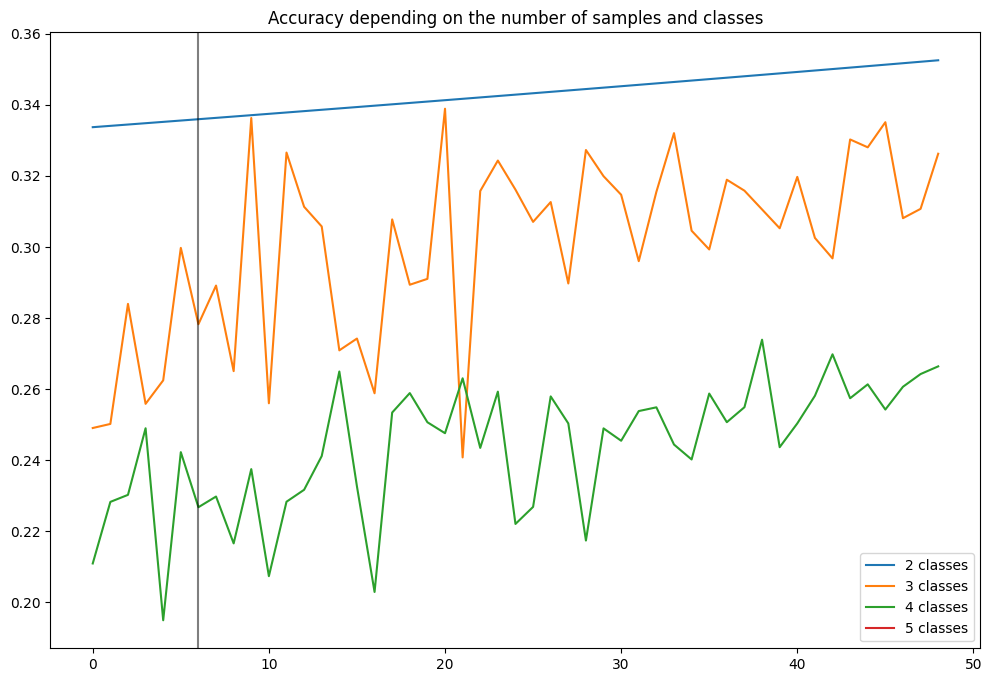

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy[2], label="2 classes")
plt.plot(all_accuracy[3], label="3 classes")
plt.plot(all_accuracy[4], label="4 classes")
plt.plot(all_accuracy[5], label="5 classes")
plt.axvline(6, c='black', alpha=0.5)
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def return_score(sample_size, num_classes):

    train, test = gen_sample(sample_size, num_classes)

    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2)
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)

    return accuracy_score(y_pred, y_test)

In [ ]:
all_accuracy_knn = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):

    for num_cl in range(2, 5):

        all_accuracy_knn[num_cl].append(return_score(num_samples,num_cl))

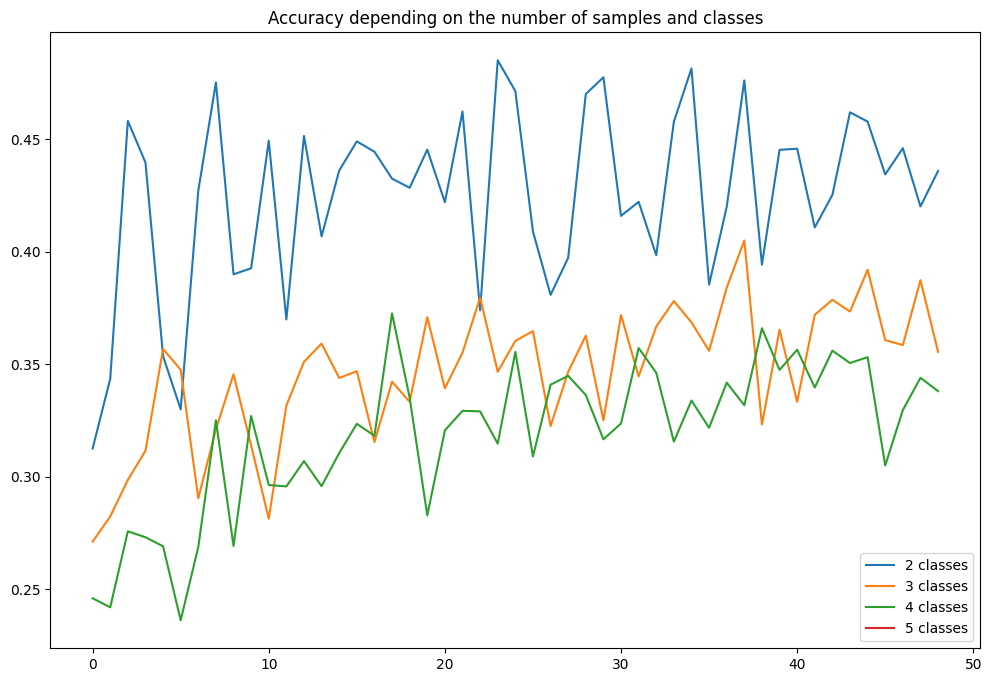

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_knn[2], label="2 classes")
plt.plot(all_accuracy_knn[3], label="3 classes")
plt.plot(all_accuracy_knn[4], label="4 classes")
plt.plot(all_accuracy_knn[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

In [ ]:
df_results = pd.DataFrame({
    'Nb Classes':[2,3,4],
    'min K-NN':[min(all_accuracy_knn[2]),
        min(all_accuracy_knn[3]),
        min(all_accuracy_knn[4])],
    'min Cosine':[min(all_accuracy[2]),
        min(all_accuracy[3]),
        min(all_accuracy[4])],
    'mean K-NN':[np.mean(all_accuracy_knn[2]),
        np.mean(all_accuracy_knn[3]),
        np.mean(all_accuracy_knn[4])],
    'mean Cosine':[np.mean(all_accuracy[2]),
        np.mean(all_accuracy[3]),
        np.mean(all_accuracy[4])],
    'max K-NN':[max(all_accuracy_knn[2]),
        max(all_accuracy_knn[3]),
        max(all_accuracy_knn[4])],
    'max Cosine':[max(all_accuracy[2]),
        max(all_accuracy[3]),
        max(all_accuracy[4])]
    })

In [ ]:
df_results

,Nb Classes,min K-NN,min Cosine,mean K-NN,mean Cosine,max K-NN,max Cosine
0,2,0.312570,0.333704,0.424959,0.342947,0.485160,0.352526
1,3,0.271172,0.240788,0.346821,0.300502,0.405074,0.338896
2,4,0.236223,0.194966,0.318901,0.243650,0.372609,0.273910


In [ ]:
import pickle

In [ ]:
# save the model to disk
filename = 'glove-twitter-25.sav'
pickle.dump(model, open(filename, 'wb'))